In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils
from wiki.newphet import load_prophet_prop
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output
import gc

In [3]:
def load_plot(page, plot_y_org=True):
    forecast = pd.read_feather(PROPHET_PATH+VERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()
    forecast = pd.read_feather(PROPHET_PATH+YVERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [4]:
PROPHET_PATH = '../data/prophet/'
CACHE_PATH = 'cache/'
RESULTS_PATH = 'results/'
VERSION ='v7t/'
YVERSION ='v7ty/'

In [5]:
mediandf = pd.read_feather('../data/median_for_120_60.f') 

In [6]:
mediandf.page_index = mediandf.page_index.astype(int)
mediandf = mediandf.sort_values(by='page_index').reset_index().drop('index', axis=1)
print(mediandf.iloc[:,2:].mean())
print(mediandf.info())
mediandf.head()

median_pred_60               945.877619
median_pred_120             1079.880355
prevYear_median_pred_60     1088.881776
prevYear_median_pred_120    1088.969089
smape_60_to_0                 41.043204
smape_120_to_60               40.059153
prevYear_smape_60_to_0        50.551424
prevYear_smape_120_to_60      47.544453
nans_start_to_120             45.414792
nans_120_to_60                 1.424264
nans_60_to_0                   1.536367
prevYear_nans_60_to_0          2.868712
prevYear_nans_120_to_60        3.540000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 15 columns):
page_index                  145063 non-null int64
Page                        145063 non-null object
median_pred_60              145063 non-null int64
median_pred_120             145063 non-null int64
prevYear_median_pred_60     145063 non-null int64
prevYear_median_pred_120    145063 non-null int64
smape_60_to_0               144151 non-null float64
s

,page_index,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,smape_60_to_0,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60
0,0,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,32.278432,25.959053,40.870388,32.116348,0,0,0,0,0
1,1,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,42.847863,34.415304,60.431899,32.054860,0,0,0,0,0
2,2,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,64.305367,65.870407,47.163640,56.748585,0,0,0,0,0
3,3,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,32.250349,33.896551,35.401843,49.278494,0,0,0,0,0
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,48.547274,38.718059,54.426324,57.220372,291,0,0,0,0


In [7]:
test_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f'); 
test_df.page_index = test_df.page_index.astype(int)
print(test_df[VERSION[:-1]+'_train'].mean())
test_df = test_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#test_df = test_df.drop(VERSION[:-1]+'_train', axis=1)
print(test_df.shape)
print(test_df.info())
print(test_df[VERSION[:-1]+'_val'].mean())
test_df.head()

66.9608163262
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7t_train     145063 non-null float64
v7t_val       144151 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
99.0350088156


,page_index,v7t_train,v7t_val
0,0,46.736751,32.642601
1,1,48.666767,83.565553
2,2,69.758611,120.451293
3,3,45.255355,38.493515
4,4,66.002965,89.498846


In [8]:
Ytest_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+YVERSION[:-1]+'df.f'); 
Ytest_df.page_index = Ytest_df.page_index.astype(int)
print(Ytest_df[YVERSION[:-1]+'_train'].mean())
Ytest_df = Ytest_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#Ytest_df = Ytest_df.drop(VERSION[:-1]+'_train', axis=1)
print(Ytest_df.shape)
print(Ytest_df.info())
print(Ytest_df[YVERSION[:-1]+'_val'].mean())
Ytest_df.head()

64.5948646161
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7ty_train    145059 non-null float64
v7ty_val      141348 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
84.8706792497


,page_index,v7ty_train,v7ty_val
0,0,47.323987,44.956479
1,1,48.262866,61.287282
2,2,71.127792,58.073251
3,3,46.191346,52.285567
4,4,62.962499,132.877882


In [9]:
df = Ytest_df.merge(test_df, on='page_index'); print(df.shape)
df = df.merge(mediandf, on='page_index'); print(df.shape)
df['Ytest_gain'] = df.prevYear_smape_60_to_0 - df[YVERSION[:-1]+'_val']
df['test_gain'] = df.smape_60_to_0 - df[VERSION[:-1]+'_val']; df.head()

(145063, 5)
(145063, 19)


,page_index,v7ty_train,v7ty_val,v7t_train,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,...,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,Ytest_gain,test_gain
0,0,47.323987,44.956479,46.736751,32.642601,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,...,25.959053,40.870388,32.116348,0,0,0,0,0,-4.086092,-0.364169
1,1,48.262866,61.287282,48.666767,83.565553,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,...,34.415304,60.431899,32.054860,0,0,0,0,0,-0.855383,-40.717689
2,2,71.127792,58.073251,69.758611,120.451293,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,...,65.870407,47.163640,56.748585,0,0,0,0,0,-10.909611,-56.145926
3,3,46.191346,52.285567,45.255355,38.493515,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,...,33.896551,35.401843,49.278494,0,0,0,0,0,-16.883725,-6.243166
4,4,62.962499,132.877882,66.002965,89.498846,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,...,38.718059,54.426324,57.220372,291,0,0,0,0,-78.451559,-40.951572


In [10]:
del Ytest_df
del test_df
del mediandf
gc.collect()

746

In [11]:
median_rolling_smape =  wiki.val.load_test_median_rolling_smape()

median_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.smape_60_to_0.fillna(-1) == median_rolling_smape.iloc[:,-60].fillna(-1)).sum() -> 145063


In [12]:
print(median_rolling_smape.iloc[[0],[0,-1]])
print(median_rolling_smape.shape)
median_rolling_smape.head()

   2015-07-01  2017-08-31
0         NaN         NaN
(145063, 793)


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,NaN,59.292576,47.521198,42.279365,43.644768,45.184539,43.202023,41.268254,42.592001,44.607579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,73.260387,69.616005,67.684029,68.770630,69.095268,70.576750,71.639287,71.655954,74.052468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,99.293651,180.000000,99.626984,101.293651,100.341270,100.722222,99.388889,99.388889,99.055556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,88.967936,70.416485,56.959173,69.960825,55.197029,60.669316,53.567910,52.966730,54.192555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
yhat_rolling_smape =  wiki.val.load_prophet_rolling_smape(VERSION, test_version=True)

prophet_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.v7t_val.round(decimals=6).fillna(-10) == yhat_rolling_smape.iloc[:,-60].round(decimals=6).fillna(-10)).sum() -> 145063


In [14]:
print(yhat_rolling_smape.iloc[[0],[0,-1]])
print(yhat_rolling_smape.shape)
yhat_rolling_smape.head()

   2015-08-30  2017-08-31
0      46.014         NaN
(145063, 733)


,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,46.01400,45.40289,45.30144,44.52684,45.14765,45.53654,46.25179,46.21211,46.71445,45.58791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53.50449,53.26103,53.13358,52.39626,52.15095,51.44100,50.79423,51.01956,52.92075,53.88034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.58922,71.25588,72.57456,72.46874,72.02430,72.02430,71.74652,72.80472,72.63806,72.16187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,53.84082,54.01158,53.71279,52.48091,52.18176,52.27033,52.99497,52.96078,53.43351,53.60186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


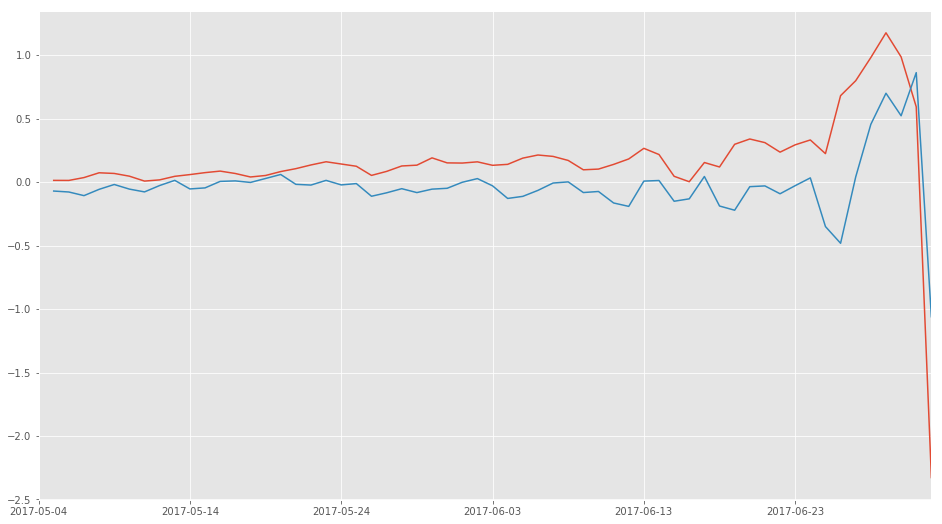

In [15]:
yhat_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()
median_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()

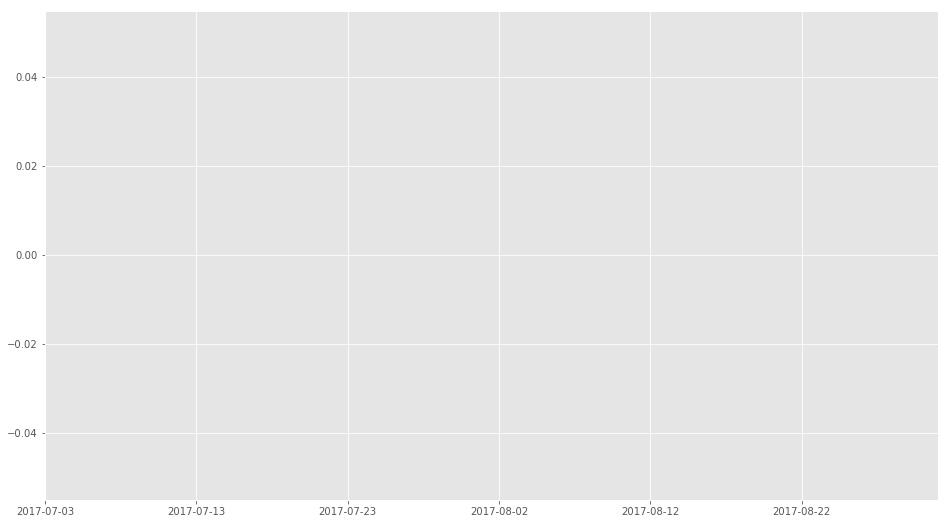

In [16]:
yhat_rolling_smape.iloc[:,-60:].diff(1, axis=1).mean(axis=0).plot()
median_rolling_smape.iloc[:,-60:].diff(1, axis=1).mean(axis=0).plot()

In [17]:
cut_off = None
df['rolling_gain_mean'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape.iloc[:,:cut_off]).mean(axis=1)
df['rolling_gain_std'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape.iloc[:,:cut_off]).std(axis=1)

In [18]:
print(df['rolling_gain_mean'].max(), df['rolling_gain_mean'].min())
print(df['rolling_gain_std'].max(), df['rolling_gain_std'].min())

200.0 -193.587283558
172.734306215 0.0


In [19]:
df.head()

,page_index,v7ty_train,v7ty_val,v7t_train,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,...,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,Ytest_gain,test_gain,rolling_gain_mean,rolling_gain_std
0,0,47.323987,44.956479,46.736751,32.642601,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,...,32.116348,0,0,0,0,0,-4.086092,-0.364169,-4.586877,7.105016
1,1,48.262866,61.287282,48.666767,83.565553,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,...,32.054860,0,0,0,0,0,-0.855383,-40.717689,-5.471587,6.573979
2,2,71.127792,58.073251,69.758611,120.451293,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,...,56.748585,0,0,0,0,0,-10.909611,-56.145926,-11.048583,13.843225
3,3,46.191346,52.285567,45.255355,38.493515,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,...,49.278494,0,0,0,0,0,-16.883725,-6.243166,-2.399449,6.971026
4,4,62.962499,132.877882,66.002965,89.498846,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,...,57.220372,291,0,0,0,0,-78.451559,-40.951572,11.684981,33.645347


In [20]:
df[['test_gain','rolling_gain_mean','rolling_gain_std']].corr()

,test_gain,rolling_gain_mean,rolling_gain_std
test_gain,1.000000,0.568253,-0.565914
rolling_gain_mean,0.568253,1.000000,-0.321331
rolling_gain_std,-0.565914,-0.321331,1.000000


# Feature Testing Area

In [134]:
yhat = wiki.newphet.load_prophet_prop(VERSION, 'yhat')
#trend = wiki.newphet.load_prophet_prop(VERSION, 'trend')
y_df = wiki.newphet.load_prophet_prop(VERSION, 'y')
Yyhat = wiki.newphet.load_prophet_prop(YVERSION, 'yhat')

In [135]:
Yyhat[yhat.columns[-60:]] = yhat.iloc[:,-60:]

In [136]:
yhat.columns[-60:]

Index(['2017-07-03', '2017-07-04', '2017-07-05', '2017-07-06', '2017-07-07',
       '2017-07-08', '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
       '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16', '2017-07-17',
       '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21', '2017-07-22',
       '2017-07-23', '2017-07-24', '2017-07-25', '2017-07-26', '2017-07-27',
       '2017-07-28', '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
       '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
       '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11',
       '2017-08-12', '2017-08-13', '2017-08-14', '2017-08-15', '2017-08-16',
       '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
       '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
       '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object')

In [137]:
Yyhat.columns[-61:]

Index(['2017-07-02', '2017-07-03', '2017-07-04', '2017-07-05', '2017-07-06',
       '2017-07-07', '2017-07-08', '2017-07-09', '2017-07-10', '2017-07-11',
       '2017-07-12', '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
       '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21',
       '2017-07-22', '2017-07-23', '2017-07-24', '2017-07-25', '2017-07-26',
       '2017-07-27', '2017-07-28', '2017-07-29', '2017-07-30', '2017-07-31',
       '2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
       '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-10',
       '2017-08-11', '2017-08-12', '2017-08-13', '2017-08-14', '2017-08-15',
       '2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20',
       '2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
       '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30',
       '2017-08-31'],
      dtype='object')

In [138]:
Yyhat.shape

(145063, 793)

In [139]:
Yyhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,19.0,15.0,16.0,15.0,14.0,10.0,13.0,12.0,8.0,10.0,...,23.0,23.0,20.0,23.0,23.0,23.0,21.0,24.0,24.0,21.0
1,22.0,21.0,24.0,31.0,24.0,25.0,31.0,30.0,27.0,28.0,...,61.0,57.0,54.0,56.0,60.0,53.0,51.0,57.0,52.0,49.0
2,3.0,1.0,0.0,2.0,2.0,1.0,0.0,3.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,1.0
3,23.0,21.0,23.0,23.0,21.0,25.0,24.0,23.0,22.0,23.0,...,12.0,12.0,10.0,11.0,12.0,9.0,12.0,10.0,10.0,8.0
4,3.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,5.0,4.0,7.0,8.0,6.0,3.0,8.0,10.0


In [140]:
yhat.iloc[:,-60:].head()

,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,24.0,26.0,25.0,22.0,24.0,23.0,22.0,20.0,22.0,22.0,...,23.0,23.0,20.0,23.0,23.0,23.0,21.0,24.0,24.0,21.0
1,45.0,53.0,50.0,49.0,51.0,57.0,50.0,49.0,55.0,50.0,...,61.0,57.0,54.0,56.0,60.0,53.0,51.0,57.0,52.0,49.0
2,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,...,0.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,1.0
3,21.0,19.0,19.0,17.0,18.0,18.0,16.0,18.0,17.0,16.0,...,12.0,12.0,10.0,11.0,12.0,9.0,12.0,10.0,10.0,8.0
4,8.0,4.0,9.0,9.0,7.0,9.0,10.0,6.0,2.0,6.0,...,0.0,4.0,5.0,4.0,7.0,8.0,6.0,3.0,8.0,10.0


yhat_org = wiki.newphet.load_prophet_prop(VERSION, 'yhat_org')
df['yhat_org_mean'] = yhat_org.iloc[:,-60:].mean(axis=1)
df['yhat_median'] = yhat.iloc[:,-60:].median(axis=1)

In [141]:
y_df = y_df.shift(365, axis=1).fillna(0)
yhat = yhat.shift(365, axis=1).fillna(0)
Yyhat = Yyhat.shift(365, axis=1).fillna(0)

In [142]:
Yyhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,16.0,16.0,15.0,17.0,19.0,19.0,18.0,21.0,21.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.0,65.0,62.0,58.0,58.0,62.0,53.0,50.0,54.0,50.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,7.0,5.0,4.0,6.0,7.0,6.0,6.0,8.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,26.0,25.0,23.0,24.0,24.0,22.0,24.0,22.0,22.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,14.0,16.0,16.0,12.0,13.0,13.0,8.0,3.0,8.0


In [143]:
train = pd.read_feather('../data/train.f')

In [192]:
lims = wiki.utils.prevYear_shift((-60,None))
df['prevYear_nans'] = 60 - train.iloc[:,lims[0]:lims[1]].count(axis=1)

In [144]:
y_df = wiki.val.get_smape_df(train,y_df)
yhat = wiki.val.get_smape_df(train,yhat)
Yyhat = wiki.val.get_smape_df(train,Yyhat)

In [145]:
yhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,55.172414,82.926829,4.081633,4.444444,4.081633,61.111111,58.823529,16.666667,4.081633,13.333333
1,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,103.448276,40.000000,96.774194,34.666667,27.848101,39.024390,27.027027,31.884058,27.848101,46.153846
2,200.0,0.0,200.0,200.0,0.0,200.0,0.0,200.0,200.0,200.0,...,40.000000,140.740741,58.823529,66.666667,40.000000,73.684211,66.666667,46.153846,82.352941,25.000000
3,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,0.000000,75.409836,19.047619,0.000000,48.275862,15.384615,22.222222,5.128205,146.456693,12.500000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.000000,200.000000,170.370370,152.000000,163.636364,142.857143,131.428571,147.826087,177.777778,120.000000


In [146]:
Yyhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,102.040816,113.513514,43.902439,42.105263,38.095238,84.848485,79.365079,36.363636,13.333333,0.000000
1,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,124.324324,62.626263,117.948718,60.674157,52.173913,61.052632,49.411765,53.164557,45.454545,66.666667
2,200.0,0.0,200.0,200.0,0.0,200.0,0.0,200.0,200.0,200.0,...,40.000000,140.740741,44.444444,46.153846,40.000000,73.684211,52.631579,28.571429,66.666667,11.764706
3,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,25.000000,47.058824,8.333333,30.000000,74.285714,13.333333,9.523810,18.181818,133.333333,37.837838
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.953488,98.181818,43.902439,31.578947,50.000000,59.459459,76.190476,85.714286,140.000000,100.000000


In [147]:
df['shift_y_smape'] = y_df.iloc[:,-60:].mean(axis=1)
df['shift_yhat_smape'] = yhat.iloc[:,-60:].mean(axis=1)
df['shift_Yyhat_smape'] = Yyhat.iloc[:,-60:].mean(axis=1)
del y_df
del yhat
del Yyhat
gc.collect()

456

In [148]:
df['shift_y_gain'] = df.smape_60_to_0 - df['shift_y_smape']
df['shift_yhat_gain'] = df.smape_60_to_0 - df['shift_yhat_smape']
df['shift_Yyhat_gain'] = df.smape_60_to_0 - df['shift_Yyhat_smape']

In [326]:
df['Ytest_gain'].mean()

-34.319254918820683

# Filter Testing

In [149]:
#BASE_SCORE = df.smape_60_to_0.mean()

In [150]:
BASE_SCORE

41.043204039840212

In [218]:
filter_df = ((df['rolling_gain_std'] < df['rolling_gain_mean']) &
            (df['Ytest_gain'] > 9)
             )
print(len(df[filter_df]))

4358


In [219]:
pd.concat([df[filter_df].v7t_val,
           df[~filter_df].smape_60_to_0]).mean()

40.941152007233562

In [220]:
pd.concat([df[filter_df].shift_y_smape,
           df[~filter_df].smape_60_to_0]).mean()

40.721997772658874

In [221]:
pd.concat([df[filter_df].shift_Yyhat_smape,
           df[~filter_df].smape_60_to_0]).mean()

40.92775684437116

In [222]:
pd.concat([df[filter_df].shift_yhat_smape,
           df[~filter_df].smape_60_to_0]).mean()

40.880627912273852

In [321]:
filter_df2 = ((df['rolling_gain_std'] < df['rolling_gain_mean']) &
            (df['Ytest_gain'] > 9) &
             (df['prevYear_nans'] <= 0)
             )
print(len(df[filter_df2]))

4254


In [322]:
pd.concat([df[filter_df2].v7t_val,
           df[~filter_df2].smape_60_to_0]).mean()

40.924415704122879

In [323]:
pd.concat([df[filter_df2].shift_y_smape,
           df[~filter_df2].smape_60_to_0]).mean()

40.67371850906175

In [324]:
pd.concat([df[filter_df2].shift_Yyhat_smape,
           df[~filter_df2].smape_60_to_0]).mean()

40.893796497608498

In [248]:
pd.concat([df[filter_df2].shift_yhat_smape,
           df[~filter_df2].smape_60_to_0]).mean()

40.846152229256759

In [315]:
filter_df3 = (
            (df['Ytest_gain'] > -10) 
             )
print(len(df[filter_df3]))

59510


In [316]:
pd.concat([df[filter_df3].v7t_val,
           df[~filter_df3].smape_60_to_0]).mean()

57.545547240381751

In [317]:
pd.concat([df[filter_df3].shift_y_smape,
           df[~filter_df3].smape_60_to_0]).mean()

50.357957840250101

In [318]:
pd.concat([df[filter_df3].shift_Yyhat_smape,
           df[~filter_df3].smape_60_to_0]).mean()

49.830074843622327

In [319]:
pd.concat([df[filter_df3].shift_yhat_smape,
           df[~filter_df3].smape_60_to_0]).mean()

51.480781200414967

In [325]:
df.Ytest_gain.mean()

-34.319254918820683

In [167]:
df[filter_df].shift_y_gain.values

array([         nan,  12.36929793,  16.67460422, ..., -21.47049083,
        73.43215152,  -7.69214997])

# Investigation of series

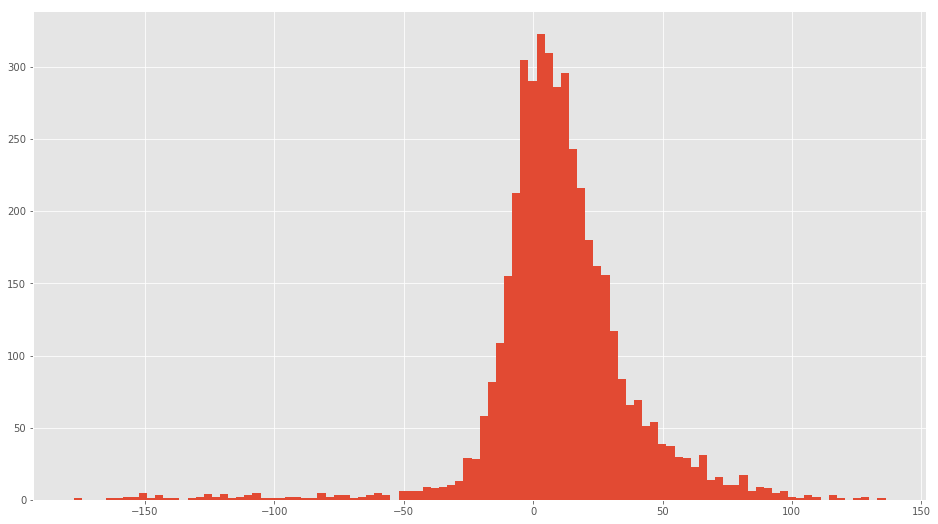

In [168]:
hist_weights = np.histogram(np.nan_to_num(df[filter_df].shift_y_gain.values), weights=np.nan_to_num(
    df[filter_df].shift_y_gain.values), bins=100)
df[filter_df].shift_y_gain.hist(bins=100)

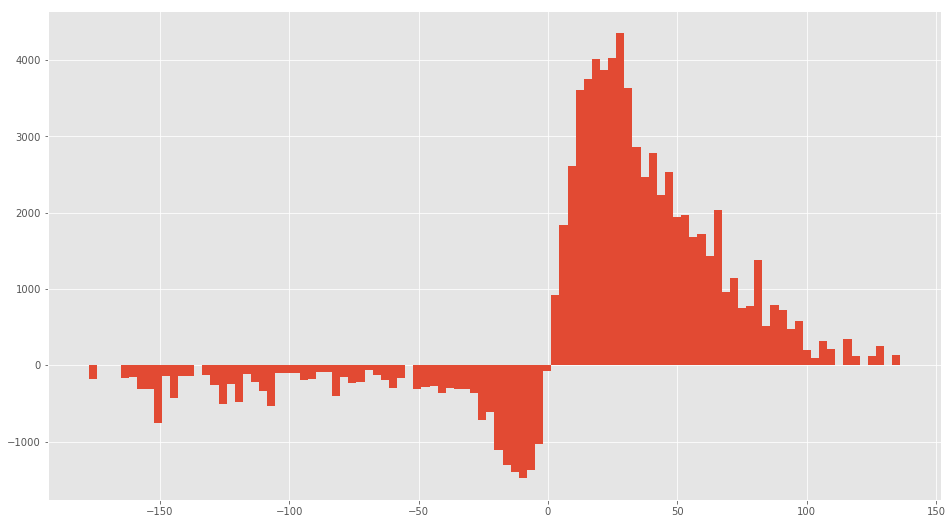

In [170]:
plpl = plt.hist(np.nan_to_num(df[filter_df].shift_y_gain.values), weights=np.nan_to_num(
    df[filter_df].shift_y_gain.values), bins=100)

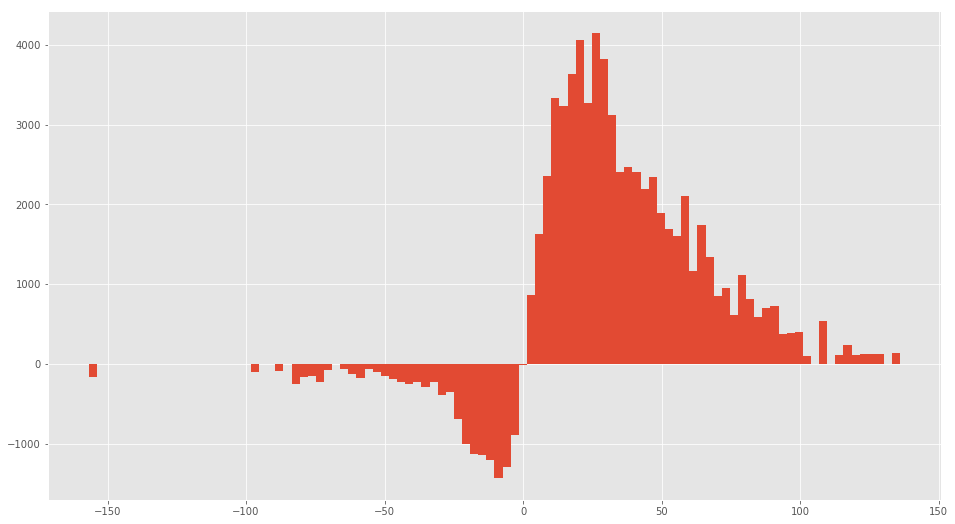

In [249]:
plpl = plt.hist(np.nan_to_num(df[filter_df2].shift_y_gain.values), weights=np.nan_to_num(
    df[filter_df2].shift_y_gain.values), bins=100)

In [279]:
len(df[filter_df3])

4216

In [257]:
(df[filter_df3].shift_y_gain > 0).sum() # 3027

3027

In [284]:
(df[filter_df3].shift_y_gain < 0).sum() # 1222

1196

In [313]:
df[(df.shift_y_gain < 0) & filter_df2].shift_y_gain.mean()

-10.505820211416694

In [314]:
df[(df.shift_y_gain > 0) & filter_df2].shift_y_gain.mean()

21.836742994911486

In [306]:
(df[(df.shift_y_gain > 0) & filter_df2].shift_y_gain.sum())/len(filter_df2) #-33.850986734170277

0.45566285714204913

In [303]:
df[(df.shift_y_gain > 0) & filter_df2].shift_y_gain.sum() + df[(df.shift_y_gain < 0) & filter_df2].shift_y_gain.sum()

53261.708747245866

In [ ]:
df[(df[filter_df2].shift_y_gain > 0)].shift_y_gain.mean() #0.28725905030559473

# Plotting best and worst

page_index                                                              17545
v7ty_train                                                            26.8838
v7ty_val                                                              24.1713
v7t_train                                                             25.9624
v7t_val                                                               16.7825
Page                        Маск,_Илон_ru.wikipedia.org_mobile-web_all-agents
median_pred_60                                                           1585
median_pred_120                                                          1750
prevYear_median_pred_60                                                   838
prevYear_median_pred_120                                                  535
smape_60_to_0                                                         19.0783
smape_120_to_60                                                       18.1408
prevYear_smape_60_to_0                                          

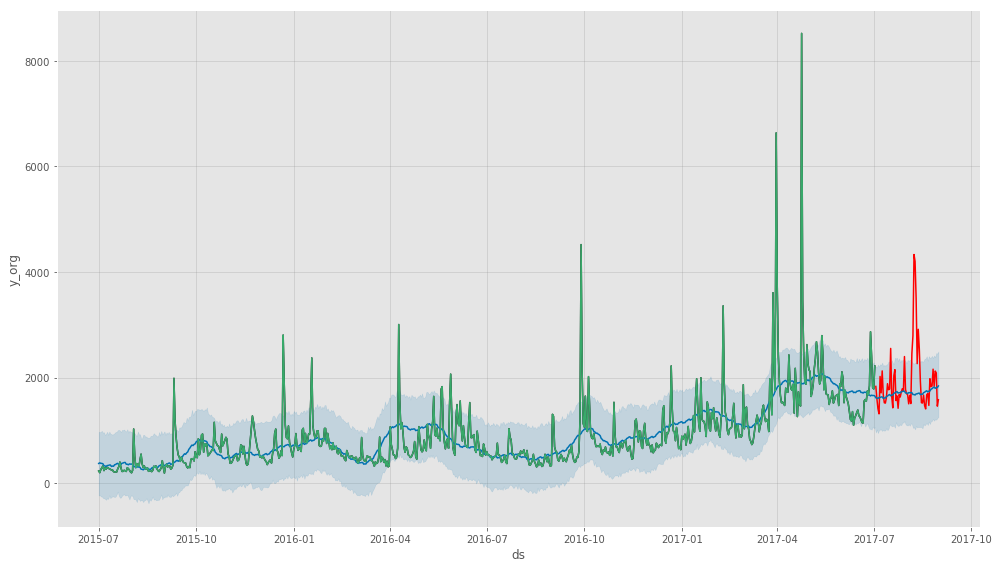

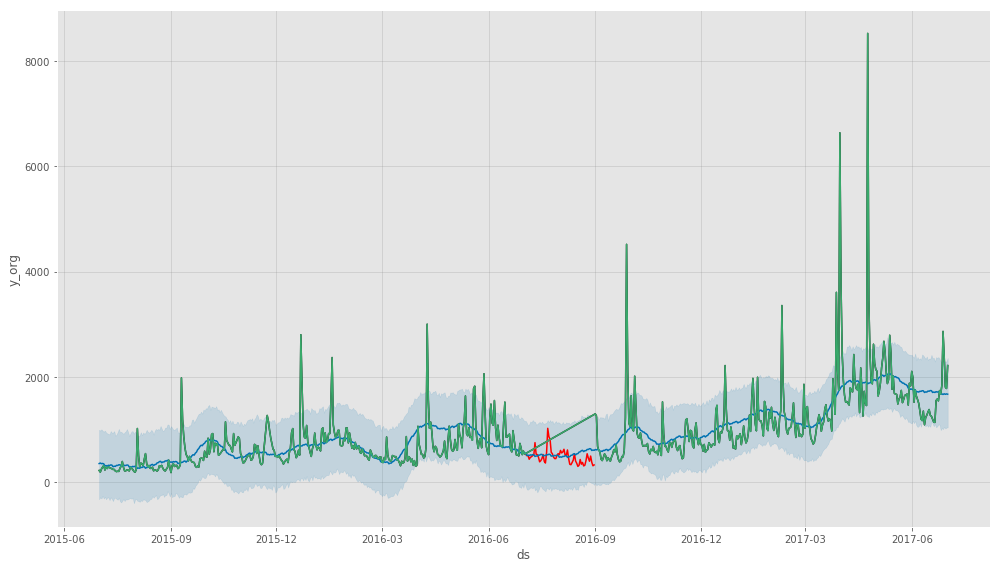

page_index                                                             116076
v7ty_train                                                            18.8354
v7ty_val                                                              12.1486
v7t_train                                                             18.1744
v7t_val                                                               69.0084
Page                        Tropical_Islands_de.wikipedia.org_mobile-web_a...
median_pred_60                                                            212
median_pred_120                                                           419
prevYear_median_pred_60                                                   545
prevYear_median_pred_120                                                  418
smape_60_to_0                                                         20.3584
smape_120_to_60                                                       65.5583
prevYear_smape_60_to_0                                          

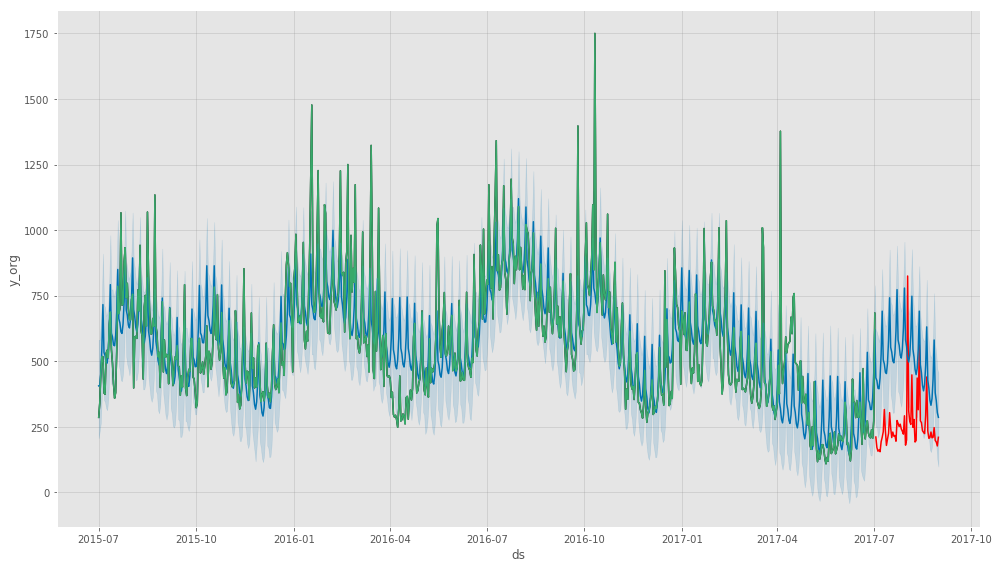

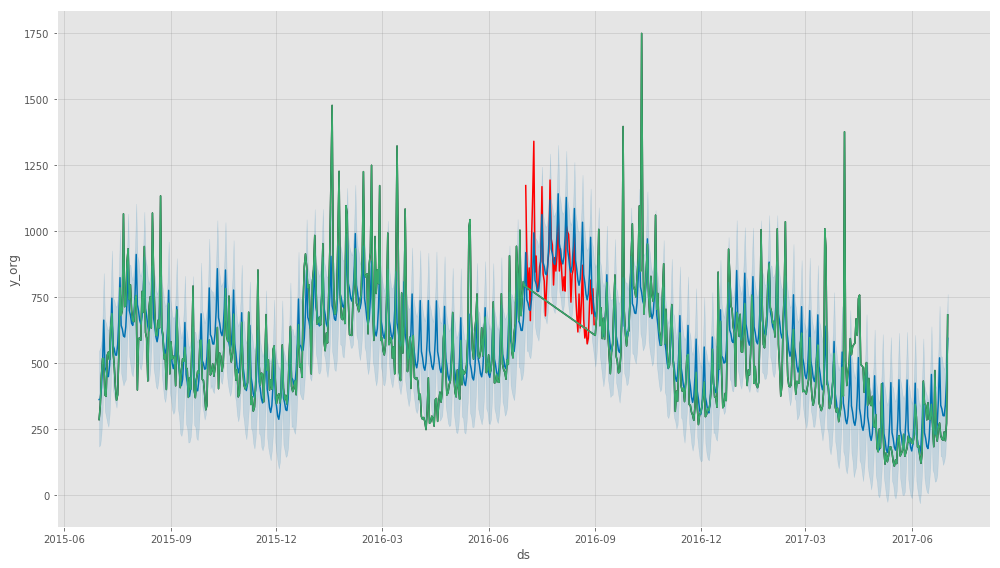

page_index                                                            102078
v7ty_train                                                           15.5975
v7ty_val                                                              35.649
v7t_train                                                            17.6394
v7t_val                                                              81.0693
Page                        Мистер_Робот_ru.wikipedia.org_desktop_all-agents
median_pred_60                                                           394
median_pred_120                                                          386
prevYear_median_pred_60                                                  657
prevYear_median_pred_120                                                 410
smape_60_to_0                                                        15.8876
smape_120_to_60                                                       9.7836
prevYear_smape_60_to_0                                               68.5665

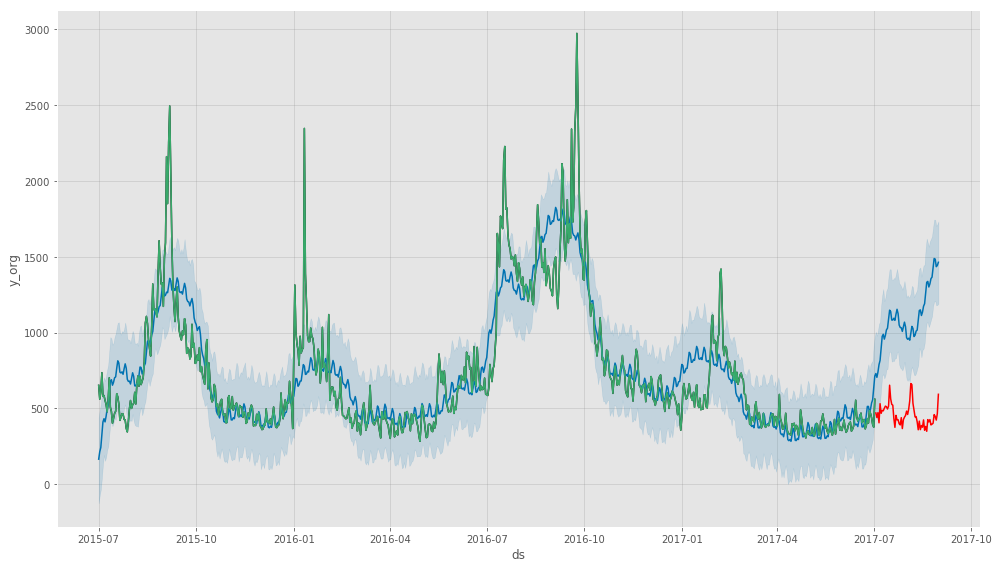

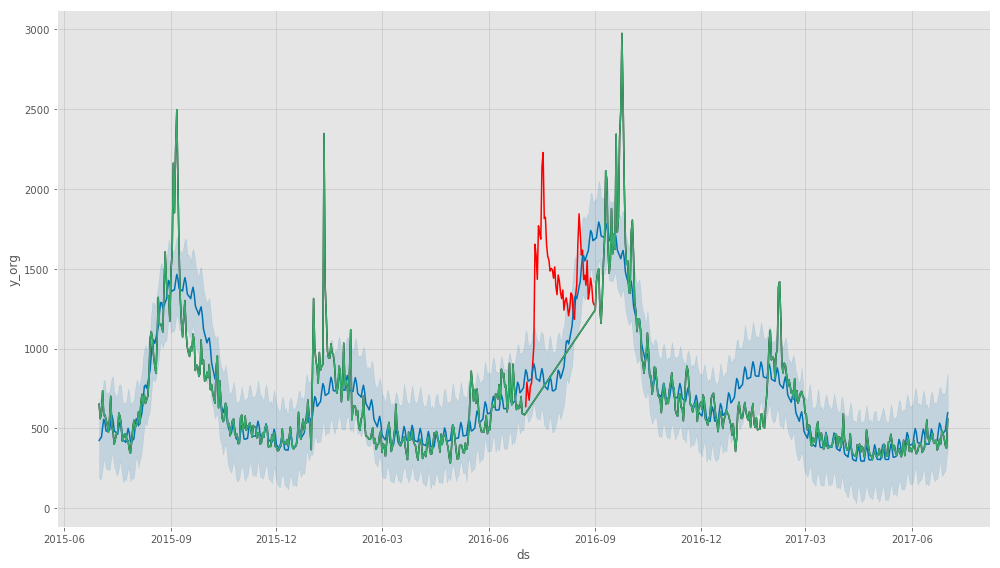

page_index                                                              99202
v7ty_train                                                            26.2285
v7ty_val                                                              22.6987
v7t_train                                                             25.4672
v7t_val                                                               18.9213
Page                        Маск,_Илон_ru.wikipedia.org_all-access_all-agents
median_pred_60                                                           3549
median_pred_120                                                          4122
prevYear_median_pred_60                                                  2347
prevYear_median_pred_120                                                 1602
smape_60_to_0                                                         17.1016
smape_120_to_60                                                       21.2083
prevYear_smape_60_to_0                                          

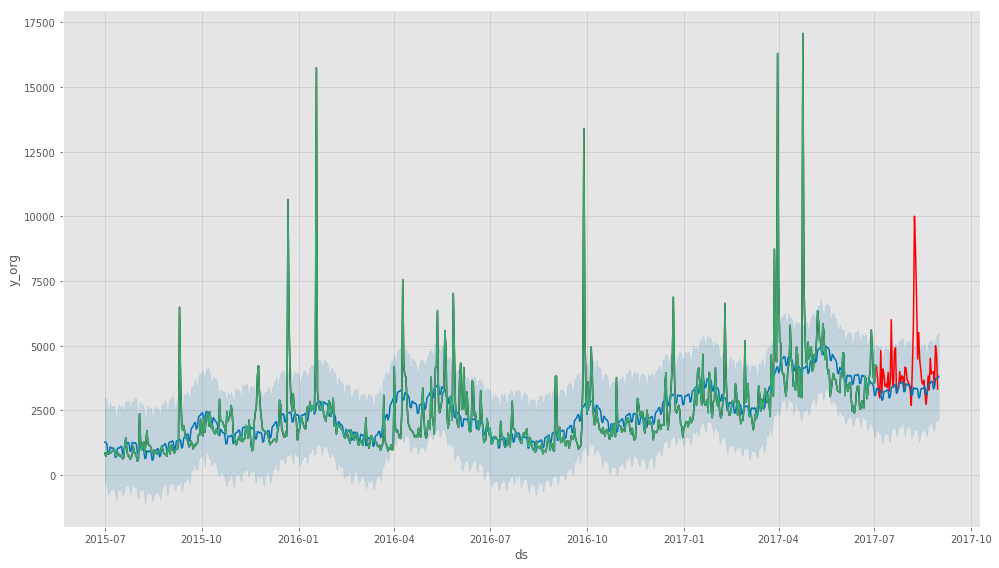

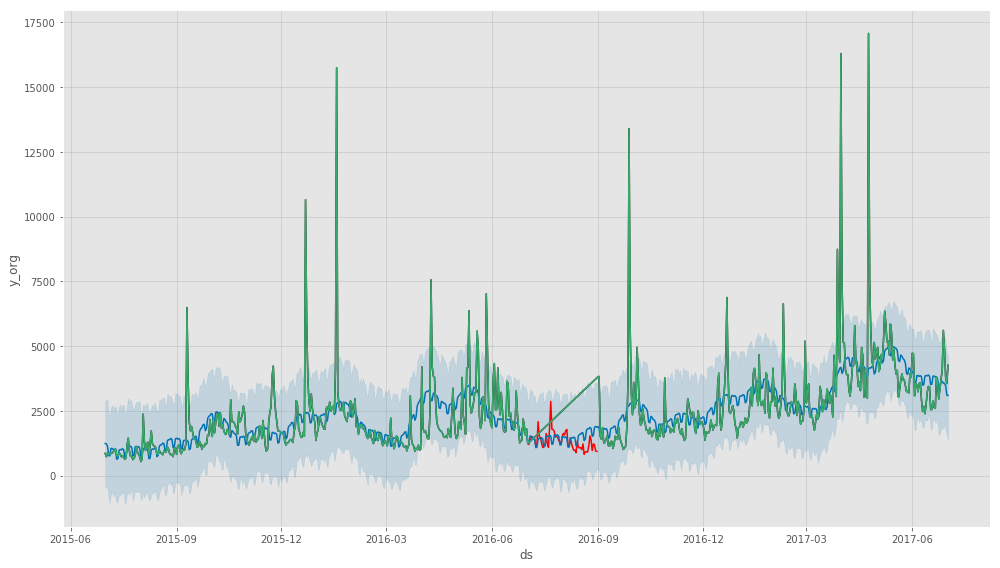

page_index                                                              98278
v7ty_train                                                            16.6327
v7ty_val                                                              34.8349
v7t_train                                                             18.8622
v7t_val                                                               80.8947
Page                        Мистер_Робот_ru.wikipedia.org_all-access_all-a...
median_pred_60                                                            667
median_pred_120                                                           680
prevYear_median_pred_60                                                   997
prevYear_median_pred_120                                                  609
smape_60_to_0                                                         13.2589
smape_120_to_60                                                       9.40771
prevYear_smape_60_to_0                                          

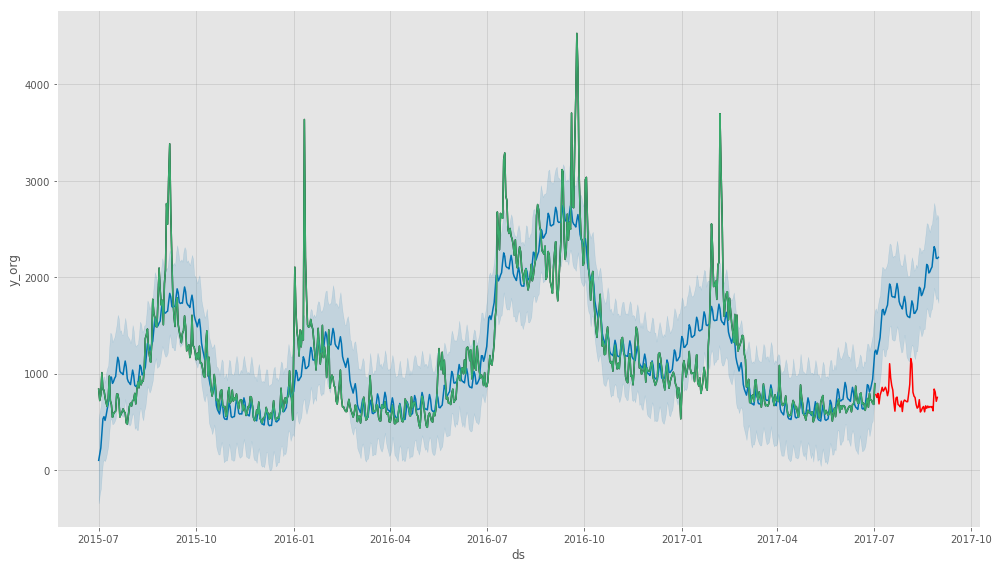

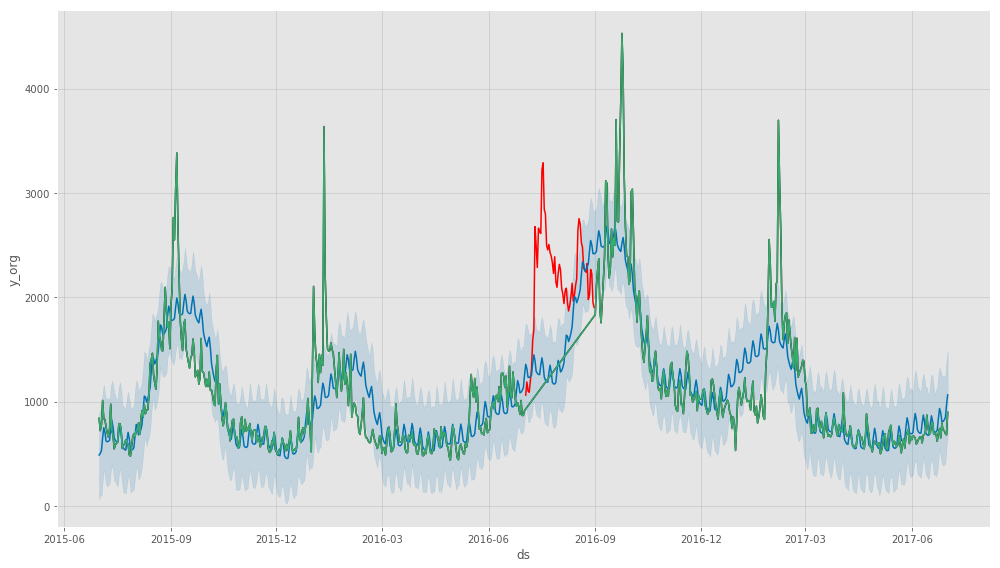

page_index                                                              92967
v7ty_train                                                            14.6328
v7ty_val                                                              19.7017
v7t_train                                                              15.166
v7t_val                                                               59.2365
Page                        Señora_Acero_es.wikipedia.org_all-access_all-a...
median_pred_60                                                           1166
median_pred_120                                                          1430
prevYear_median_pred_60                                                  2273
prevYear_median_pred_120                                                 1796
smape_60_to_0                                                          15.041
smape_120_to_60                                                        22.218
prevYear_smape_60_to_0                                          

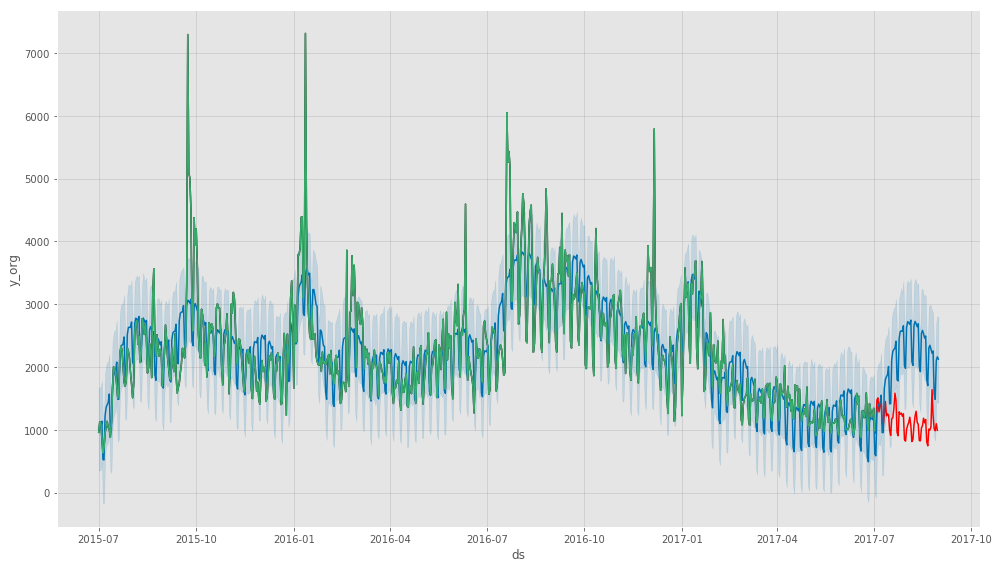

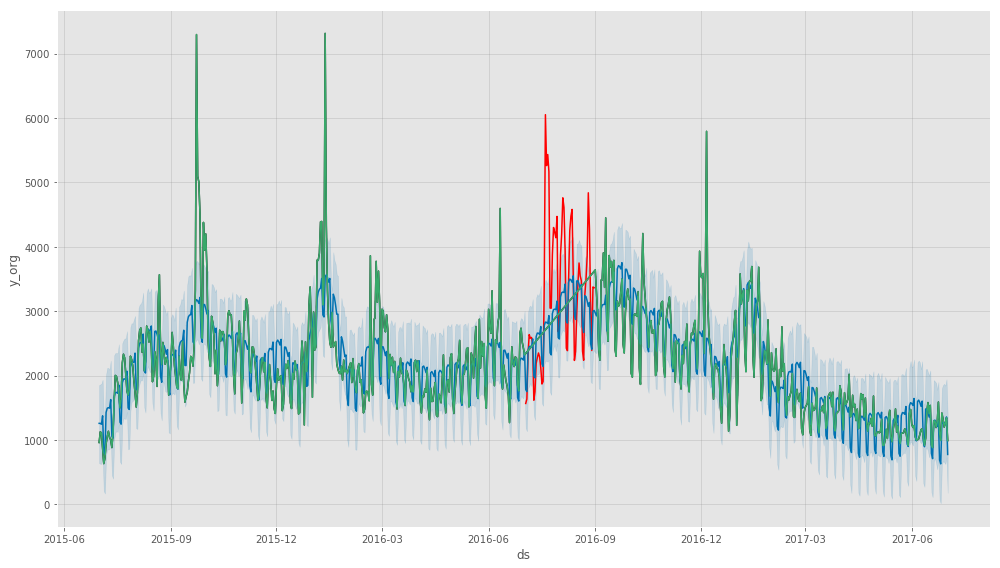

page_index                                                             4775
v7ty_train                                                          19.3223
v7ty_val                                                            38.6652
v7t_train                                                            23.485
v7t_val                                                             79.4034
Page                        Dave_Franco_fr.wikipedia.org_desktop_all-agents
median_pred_60                                                          166
median_pred_120                                                         205
prevYear_median_pred_60                                                 234
prevYear_median_pred_120                                                168
smape_60_to_0                                                       21.2055
smape_120_to_60                                                     29.3508
prevYear_smape_60_to_0                                              83.1357
prevYear_sma

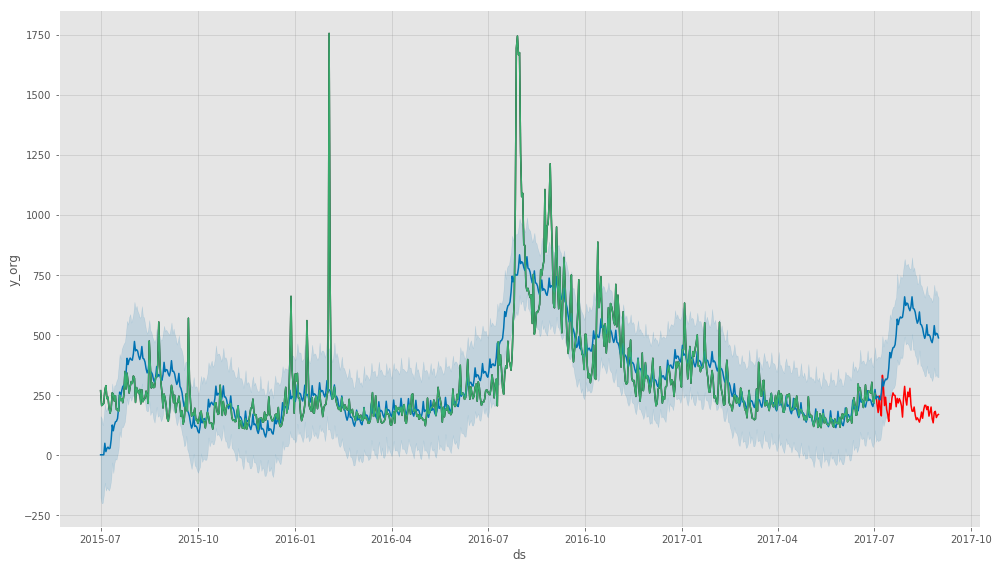

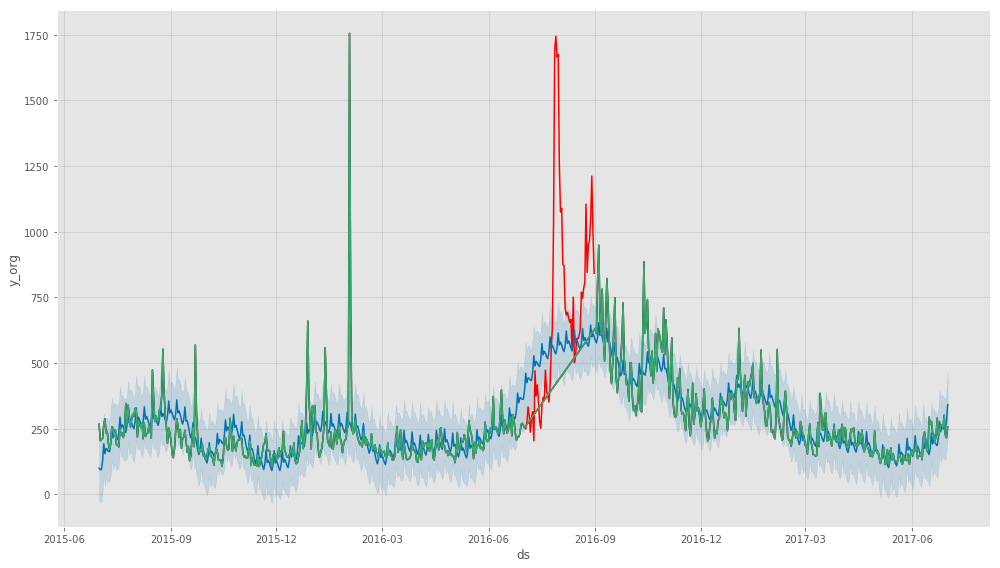

page_index                                                              96649
v7ty_train                                                            15.5252
v7ty_val                                                              19.9322
v7t_train                                                             16.0297
v7t_val                                                               60.5144
Page                        Señora_Acero_es.wikipedia.org_mobile-web_all-a...
median_pred_60                                                            847
median_pred_120                                                          1017
prevYear_median_pred_60                                                  1586
prevYear_median_pred_120                                                 1277
smape_60_to_0                                                         17.2938
smape_120_to_60                                                       23.4399
prevYear_smape_60_to_0                                          

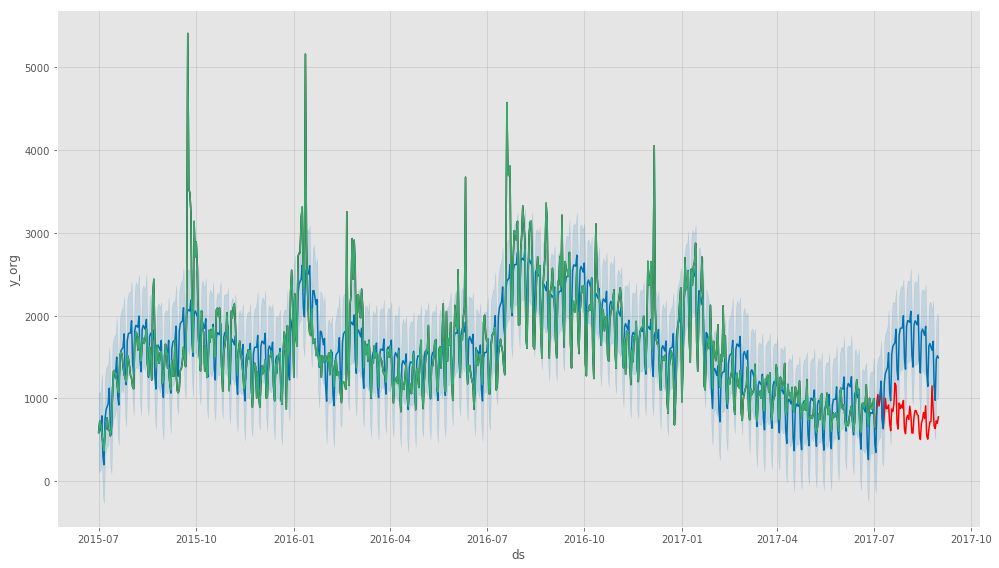

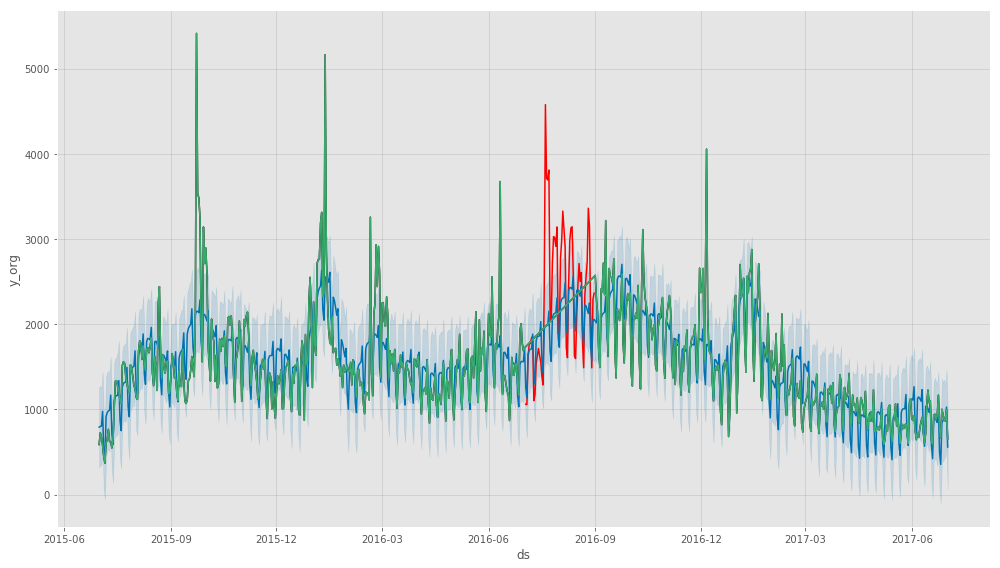

page_index                                                              16578
v7ty_train                                                            21.4975
v7ty_val                                                              35.7048
v7t_train                                                             24.3272
v7t_val                                                               77.0066
Page                        Мистер_Робот_ru.wikipedia.org_mobile-web_all-a...
median_pred_60                                                            263
median_pred_120                                                           280
prevYear_median_pred_60                                                   320
prevYear_median_pred_120                                                  193
smape_60_to_0                                                         14.4396
smape_120_to_60                                                       14.0124
prevYear_smape_60_to_0                                          

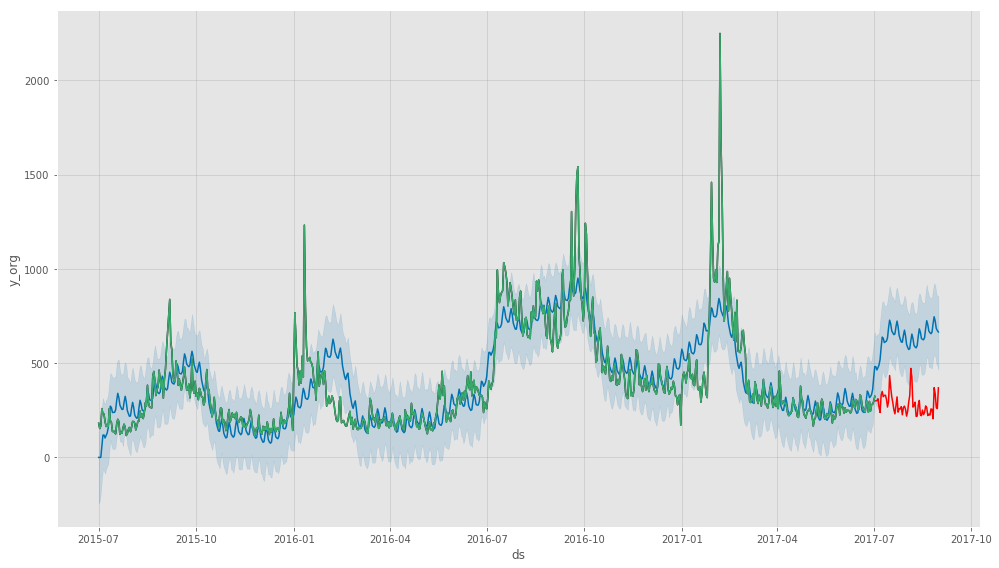

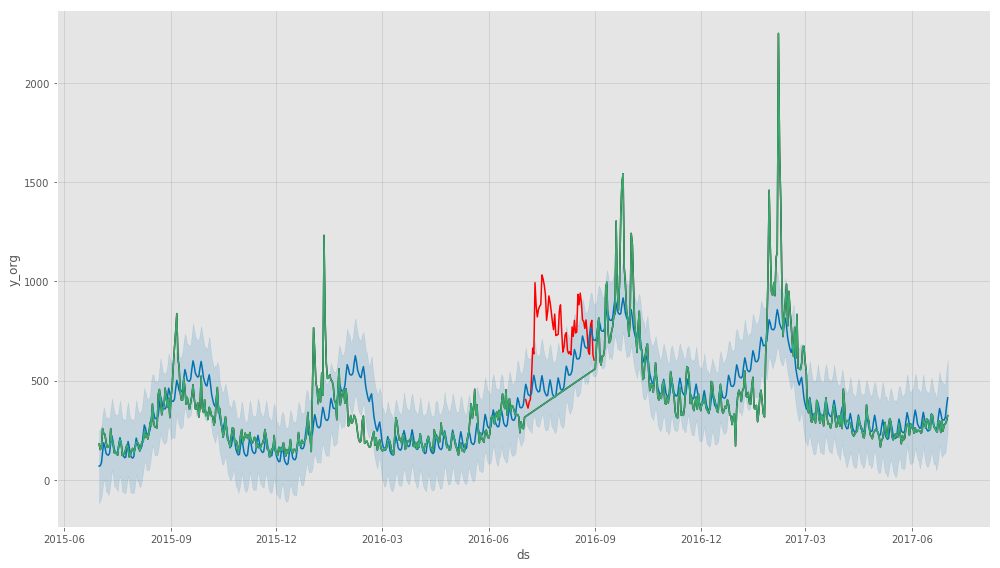

page_index                                                      63161
v7ty_train                                                    16.9201
v7ty_val                                                      32.0004
v7t_train                                                     18.4151
v7t_val                                                       53.5377
Page                        主君的太陽_zh.wikipedia.org_desktop_all-agents
median_pred_60                                                    292
median_pred_120                                                   375
prevYear_median_pred_60                                           413
prevYear_median_pred_120                                          549
smape_60_to_0                                                 11.4475
smape_120_to_60                                               22.6325
prevYear_smape_60_to_0                                        47.5474
prevYear_smape_120_to_60                                      25.7762
nans_start_to_120   

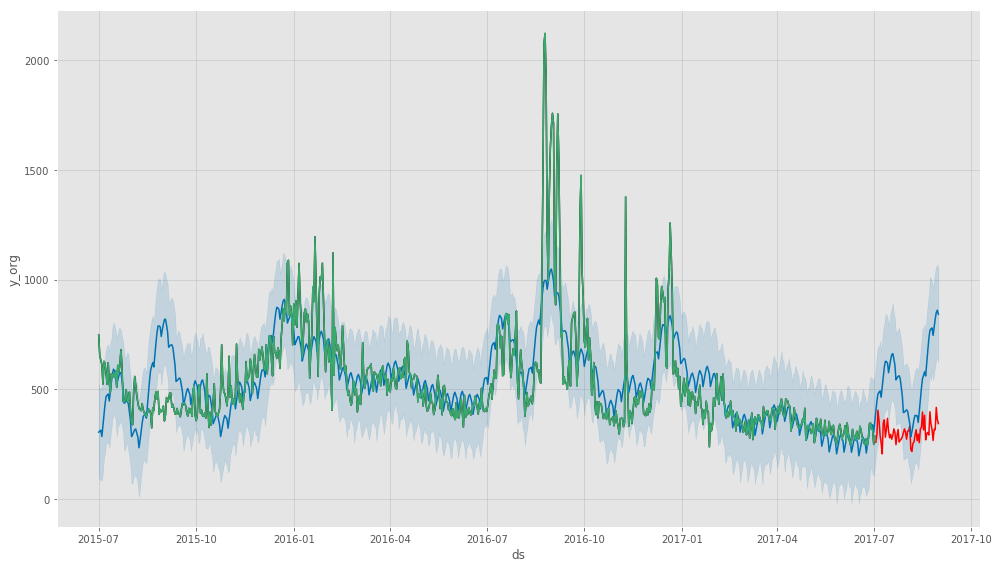

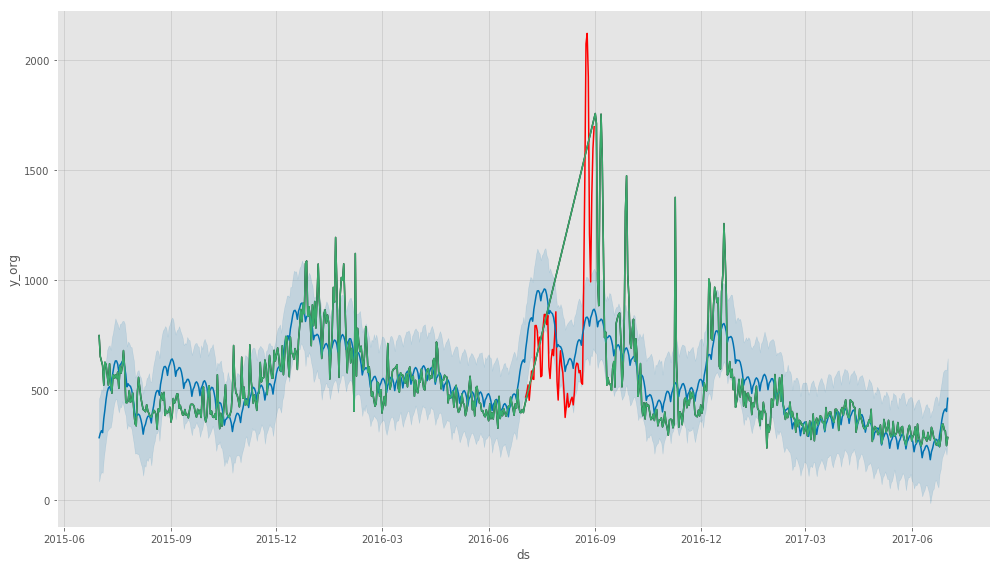

In [277]:
# worst
for row in df[filter_df3].sort_values(
    by='shift_y_gain', ascending=True).iloc[10:10].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [253]:
# best
for row in df[filter_df].sort_values(
    by='shift_y_gain', ascending=False).iloc[0:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

# Saving Results 

In [ ]:
# save the pages and val scores
df[filter_df][['page_index','v7t_val']].reset_index().drop('index', axis=1).to_feather(
    #'../data/prophet/results/proph_v7_vals.f')

In [ ]:
# save the pages and val scores
# need to grab yhat here I think
yhat[filter_df].iloc[:,-60:].reset_index().rename(columns={'index':'page_index'}).to_feather(
    #'../data/prophet/results/proph_v7_preds.f')